In [9]:
import joblib
import numpy as np
from sklearn.decomposition import PCA
import os
import nibabel as nib
from os.path import join as pjoin
from scipy.stats import zscore
from utils import get_roi_data, save_ciftifile
import matplotlib.pyplot as plt

## Alexnet encoding model params

In [18]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
model_path = os.path.join(wk_dir, 'mappings')
subs = [f'sub-0{i+1}' for i in list(range(9))]
# subs.pop(2)
bmaskname = 'subjvis'
layername = 'features3'
modelname = 'RFmodels'

model_params_inbrain = np.nan*np.zeros((len(subs), 59412, 192))
selected_counts = np.zeros(59412)
shared_voxels = set(np.arange(59412).tolist())
pca_loadings = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/pca-axis/group_pcacomp.npy')

# sub = subs[0]
exp_ratios = np.zeros((len(subs), 10))
for isub, sub in enumerate(subs):
    submask = np.zeros(59412)
    submodelpath = pjoin(model_path, f'{sub}/{sub}_bm-{bmaskname}_layer-{layername}_{modelname}.pkl')
    submodel = joblib.load(submodelpath)

    submodel_params = np.zeros((59412, 192))
    submodel_params[np.array(list(submodel.keys())), :] = np.stack([ model.coef_ for model in submodel.values() ], axis=0)

    voxel_indices = np.array(list(submodel.keys()))
    # select ROI names
    evc_pool = ['V1', 'V2', 'V3','V4']
    # vtc_pool = ['V8', 'PIT', 'FFC', 'VVC', 'VMV1', 'VMV2', 'VMV3']
    # aggregate ROI vertices
    roi_name = [__  for _ in [evc_pool] for __ in _]
    # form ROI mask
    selection_mask = np.sum([get_roi_data(None, _) for _ in roi_name], axis=0)
    # trsnfer to indices in cifti space
    voxel_indices = np.array([ _ for _ in np.where(selection_mask==1)[0] if _ in voxel_indices])

    params = submodel_params[voxel_indices, :]

    params = zscore(params)
    trans_params = np.matmul(params, pca_loadings.T)

    brainmap = np.nan * np.zeros((10, 91282))
    brainmap[:, np.array(voxel_indices)] = trans_params.transpose()

    save_ciftifile(brainmap, f'./brainmap/{sub}_layer-{layername}_params_vis-components.dtseries.nii')

    sub_total_var = np.var(params.flatten())
    sub_exp_ratio = [np.var(trans_params[:,i])/sub_total_var for i in range(10)]
    exp_ratios[isub, :] = np.array(sub_exp_ratio)


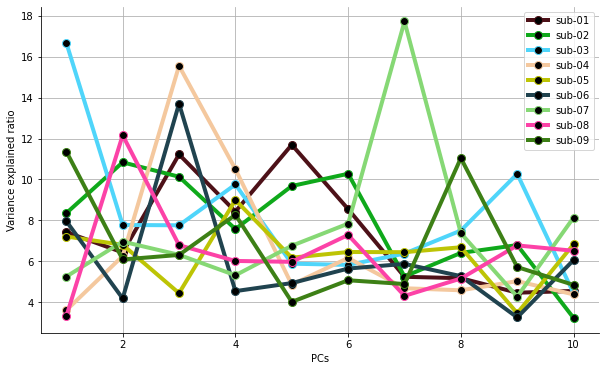

In [27]:
plt.figure(figsize=(10, 6))

# Plotting the line
x = np.arange(10) + 1
hex_color_codes = ['#4D1118', '#0FA91B', '#4FD5FA', '#F4C89E', '#BDC405', '#20434F', '#86D875', '#FC42A7', '#3D8016']

for i in range(len(subs)):
    plt.plot(x, exp_ratios[i,:], '-o', color=hex_color_codes[i], markerfacecolor='black', 
             markersize=8, label=f'{subs[i]}', lw=4)
plt.legend()
# Hide the top and right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('PCs')
plt.ylabel('Variance explained ratio')
plt.title('')
plt.grid(True)
plt.show()

In [7]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
model_path = os.path.join(wk_dir, 'mappings')
subs = [f'sub-0{i+1}' for i in list(range(9))]
# subs.pop(2)
bmaskname = 'subjvis'
layername = 'features3'
modelname = 'RFmodels'

model_params_inbrain = np.nan*np.zeros((len(subs), 59412, 192))
selected_counts = np.zeros(59412)
shared_voxels = set(np.arange(59412).tolist())

sub = subs[0]
submask = np.zeros(59412)
submodelpath = pjoin(model_path, f'{sub}/{sub}_bm-{bmaskname}_layer-{layername}_{modelname}.pkl')
submodel = joblib.load(submodelpath)

submodel_params = np.zeros((59412, 192))
submodel_params[np.array(list(submodel.keys())), :] = np.stack([ model.coef_ for model in submodel.values() ], axis=0)

In [9]:
voxel_indices = np.array(list(submodel.keys()))
# select ROI names
evc_pool = ['V1', 'V2', 'V3','V4']
# vtc_pool = ['V8', 'PIT', 'FFC', 'VVC', 'VMV1', 'VMV2', 'VMV3']
# aggregate ROI vertices
roi_name = [__  for _ in [evc_pool] for __ in _]
# form ROI mask
selection_mask = np.sum([get_roi_data(None, _) for _ in roi_name], axis=0)
# trsnfer to indices in cifti space
voxel_indices = np.array([ _ for _ in np.where(selection_mask==1)[0] if _ in voxel_indices])

params = submodel_params[voxel_indices, :]

params = zscore(params)

In [10]:
params.shape

(2519, 192)

In [11]:
pca_loadings = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/pca-axis/group_pcacomp.npy')

In [13]:
trans_params = np.matmul(params, pca_loadings.T)
trans_params.shape

(2519, 10)

In [14]:
brainmap = np.nan * np.zeros((10, 91282))
brainmap[:, np.array(voxel_indices)] = trans_params.transpose()


save_ciftifile(brainmap, f'./brainmap/{sub}_layer-{layername}_params_vis-components.dtseries.nii')


In [16]:
total_var = np.var(params.flatten())
exp_ratio = [np.var(trans_params[:,i])/total_var for i in range(10)]
exp_ratio

[7.425285100901001,
 6.436356879474318,
 11.223588161063432,
 8.432100466316264,
 11.695478182187985,
 8.552701167126788,
 5.244799014516453,
 5.177867284694855,
 4.467501666319785,
 4.5545212062770135]

## googlenet params encoding model

### collecting all subjects' encoding params

In [11]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
model_path = os.path.join(wk_dir, 'build/mappings')
subs = [f'sub-0{i+1}' for i in list(range(9))]#+1[3,4,5,8]
bmaskname = 'subjvis'
layername = 'googlenet-inception3a'
modelname = 'RFmodels'

model_params_inbrain = np.nan*np.zeros((len(subs), 59412, 256))
selected_counts = np.zeros(59412)

for i, sub in enumerate(subs):
    submask = np.zeros(59412)
    submodelpath = pjoin(model_path, f'{sub}/{sub}_bm-{bmaskname}_layer-{layername}_{modelname}.pkl')
    submodel = joblib.load(submodelpath)

    submask[np.array(list(submodel.keys()))] = 1
    selected_counts += submask
    
    submodel_params = np.stack([ model.coef_ for model in submodel.values() ], axis=0)
    model_params_inbrain[i, np.array(list(submodel.keys())), :] = submodel_params

ave_model_params_inbrain = np.nanmean(model_params_inbrain, axis=0)



<ipython-input-11-89792f8d2a60>:22: RuntimeWarning: Mean of empty slice
  ave_model_params_inbrain = np.nanmean(model_params_inbrain, axis=0)


In [56]:
np.unique(selected_counts),len(np.where(selected_counts>=1)[0])

(array([0., 1., 2., 6., 7., 8., 9.]), 9689)

### select vertices in specific ROI

In [55]:
count_treshold = 6
shared_voxel_indices = np.where(selected_counts>=count_treshold)[0]

#### selection by MMP

In [ ]:
count_treshold = 1
voxel_indices = np.where(selected_counts>=count_treshold)[0]

# select ROI names
evc_pool = ['V1']#, 'V2', 'V3','V4'  
# vtc_pool = ['V8', 'PIT', 'FFC', 'VVC', 'VMV1', 'VMV2', 'VMV3']
# aggregate ROI vertices
roi_name = [__  for _ in [evc_pool] for __ in _]
# form ROI mask
selection_mask = np.sum([get_roi_data(None, _) for _ in roi_name], axis=0)
# trsnfer to indices in cifti space
voxel_indices = np.array([ _ for _ in np.where(selection_mask==1)[0] if _ in voxel_indices])

In [113]:
single_roi = 'V4'
vis_pool = [single_roi]#'V1', 'V2', 'V3','V4'
roi_name = [__  for _ in [vis_pool] for __ in _]
roi_mask = np.sum([get_roi_data(None, _) for _ in roi_name], axis=0)[0:59412]

maskname = 'MMP'
stack_params = []
for i, sub in enumerate(subs):
    submask = np.zeros(59412)
    submodelpath = pjoin(model_path, f'{sub}/{sub}_bm-{bmaskname}_layer-{layername}_{modelname}.pkl')
    submodel = joblib.load(submodelpath)

    submask[np.array(list(submodel.keys()))] = 1
    mask = submask + roi_mask
    # print(np.unique(mask))
    sub_voxels = np.where(mask==2)[0]
    stack_params.append(model_params_inbrain[i, sub_voxels, :])

concat_params = np.concatenate(stack_params)
save_dir =pjoin(wk_dir, 'anal/voxel-tuning/MMP')
if len(vis_pool)==1:
    np.save(pjoin(save_dir, f'concat_bm-{maskname}_ly-inception3a_roi-{single_roi}.npy'), concat_params)
else:
    np.save(pjoin(save_dir, f'concat_bm-{maskname}_ly-inception3a_roi-evis.npy'), concat_params)
concat_params.shape,len(np.unique(np.where(np.isnan(concat_params)==1)[0]))

((5741, 256), 0)

In [59]:
np.sum(roi_mask==1)

4193

#### selection by subject mask

In [42]:
mask_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/voxel_masks'
maskname = 'gmmret'
gmmret_mask = nib.load(pjoin(mask_dir,f'nod-voxmask_{maskname}-in-subj.dlabel.nii')).get_fdata()

In [53]:
single_roi = 'V4'
vis_pool = [single_roi]#'V1', 'V2', 'V3','V4'
roi_name = [__  for _ in [vis_pool] for __ in _]
roi_mask = np.sum([get_roi_data(None, _) for _ in roi_name], axis=0)[0:59412]
gmmret_roi_mask = np.zeros_like(gmmret_mask)
for i in range(gmmret_roi_mask.shape[0]):
    gmmret_roi_mask[i] = np.logical_and(gmmret_mask[i,:], roi_mask)
    print('sub', i+1, ':', np.sum(gmmret_roi_mask[i]) )

concat_params = np.concatenate([model_params_inbrain[i, np.where(gmmret_roi_mask[i]==1), :] for i in range(9)], axis=1)[0]
# save_dir =pjoin(wk_dir, 'anal/voxel-tuning/SUB')
# if len(vis_pool)==1:
#     np.save(pjoin(save_dir, f'concat_bm-{maskname}_ly-inception3a_roi-{single_roi}.npy'), concat_params)
# else:
#     np.save(pjoin(save_dir, f'concat_bm-{maskname}_ly-inception3a_roi-evis.npy'), concat_params)
# concat_params.shape

sub 1 : 621.0
sub 2 : 613.0
sub 3 : 603.0
sub 4 : 640.0
sub 5 : 631.0
sub 6 : 353.0
sub 7 : 608.0
sub 8 : 637.0
sub 9 : 639.0


In [38]:
np.sum(roi_mask)

642

In [21]:
roi_mask.shape,gmmret_roi_mask.shape[0]

((91282,), 9)

### generate different masks

In [47]:
gmmretmaskrepeats = nib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/voxel_masks/nod-voxmask_gmmret-in-subj-repeats.dscalar.nii').get_fdata()[0]
print(np.unique(gmmretmaskrepeats),np.sum(gmmretmaskrepeats>=9))
full_voxel_indices = np.where(selected_counts>=6)[0]
subshared_indices = np.where(gmmretmaskrepeats>=9)[0]

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 4071


In [48]:
full_v1 = [_ for _ in np.where(get_roi_data(None, 'V1'))[0] if _ in full_voxel_indices] 
shrd_v1 = [_ for _ in np.where(get_roi_data(None, 'V1'))[0] if _ in subshared_indices] 
full_v2 = [_ for _ in np.where(get_roi_data(None, 'V2'))[0] if _ in full_voxel_indices] 
shrd_v2 = [_ for _ in np.where(get_roi_data(None, 'V2'))[0] if _ in subshared_indices] 
full_v3 = [_ for _ in np.where(get_roi_data(None, 'V3'))[0] if _ in full_voxel_indices] 
shrd_v3 = [_ for _ in np.where(get_roi_data(None, 'V3'))[0] if _ in subshared_indices] 
full_v4 = [_ for _ in np.where(get_roi_data(None, 'V4'))[0] if _ in full_voxel_indices] 
shrd_v4 = [_ for _ in np.where(get_roi_data(None, 'V4'))[0] if _ in subshared_indices] 
full_vis = [_ for _ in np.where(get_roi_data(None, ['V1', 'V2', 'V3', 'V4']))[0] if _ in full_voxel_indices] 
shrd_vis = [_ for _ in np.where(get_roi_data(None, ['V1', 'V2', 'V3', 'V4']))[0] if _ in subshared_indices] 

In [49]:
echo = lambda x : exec(f"print('{x}',len(full_{x}), len(shrd_{x}))")
echo('v1'), echo('v2'), echo('v3'), echo('v4'), echo('vis')


v1 1628 631
v2 1229 567
v3 694 475
v4 642 595
vis 4193 2268


(None, None, None, None, None)

### PCA

In [115]:
layername = 'Incep3a'

maskname_mask_dict = {'fullv1':full_v1, 'fullv2':full_v2,'fullv3':full_v3, 'fullv4':full_v4,
                      'shrdv1':shrd_v1, 'shrdv2':shrd_v2, 'shrdv3':shrd_v3, 'shrdv4':shrd_v4,
                      'fullvis':full_vis, 'shrdvis':shrd_vis}
for name, msk in maskname_mask_dict.items():
    # ----------------------------------
    mask_name = name  #'fullv4'
    voxel_indices = np.array(msk) #np.array(full_v4)
    # ----------------------------------
    params = ave_model_params_inbrain[voxel_indices, :]
    params = zscore(params)

    n_comp = 10
    pca = PCA(n_components=10)
    pca.fit(params)
    pca_axis = pca.components_
    np.save(f'./anal/pca-axis/sub-avg_ly-{layername}_bm-{mask_name}_axis.npy', pca_axis)

    trans_params = pca.transform(params)
    brainmap = np.nan * np.zeros((10, 91282))
    brainmap[:, np.array(voxel_indices)] = trans_params.transpose()
    save_ciftifile(brainmap, f'./anal/brainmap/sub-avg_ly-{layername}_bm-{mask_name}_params-components.dtseries.nii')


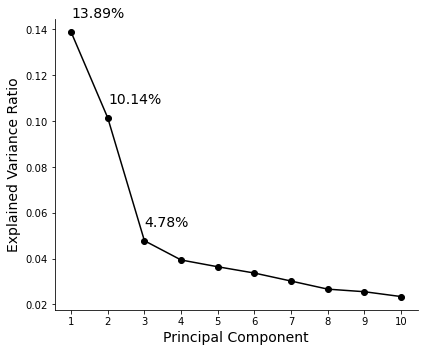

In [94]:
# 根据要求，将方差百分比标注向上和向右侧偏移
explained_variance_ratio = pca.explained_variance_ratio_

# 创建新的碎石图
plt.figure(figsize=(6, 5))
plt.plot(range(1, 11), explained_variance_ratio, marker='o', linestyle='-', color='black')

# 在每个点旁边偏移地添加方差百分比标签
for i, v in enumerate(explained_variance_ratio):
    if v >=0.045:
        plt.text(i + 1.01, v + 0.005, f"{v:.2%}", ha='left', va='bottom', fontsize=14)

# 隐藏右侧和顶侧的轴线
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 设置轴标签和标题
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
# plt.title('Scree Plot of PCA Components', fontsize=16)
plt.xticks(range(1, 11))

# 显示图形
plt.tight_layout()
plt.show()


### single channel statistics

#### channel labels

In [15]:
incep3a_labels = {'lindends':[133,96], 
 'thinklines':[140,78,89],
 'crosses/diverginglines':[91,185,64,118],
 'eyes/smallcircles':[174,168,79,125,175],
 'furprecursors':[46,47,26,63,80,23,16],
 'angles':[188,94,164,107,77,157,149,100],
 'bwvscolor': [214,208,201,223,210,197,222,204,220],
 'curves':[81,104,92,145,95,163,171,71,147,189,137],
 'repeatingpartterns':[237,31,17,20,39,126,124,156,98,105,230,228],
 'otherunits':[38,43,58,67,190,109,122,128,142,143,155,170,179,184],
 'lines':[227,75,146,69,169,57,154,187,27,134,150,240,101,176],
 'linemisc':[191, 121,116,14,24,0,159,152,165,83,173,87,90,82],
 'complexcenter-surround':[178,181,161,166,172,68,130,49,52,114,115,120,144,37],
 'colorcontrast':[195, 84, 85, 123, 203, 217, 199, 211, 205,212,202,200, 138,32],
 'brightnessgradient':[216,127,22,182,162,25,249,15,28,59,29,196,206,18,247],
 'high-lowfrequency':[110,180,153,106,112,186,132,136,117,113,108,70,86,88,160],
 'colorcenter-surround':[119,34,167,76,19,30,131,251,226,13,7,50,1,4,41,192,36,40,103,213,10,35,221,193,158,73,74,177,97,141],
 'texture':[246,242,253,232,233,209,139,65,44,51,194,207,111,218,224,225,215,198, 62, 21,254, 255,61,2,3,8,12,53, 56, 102, 148, 244, 250,11, 238,248,9,219, 234, 252, 236, 5,183, 241, 229, 93,243, 99,45,33,135,231,60, 235,48,55,42,151,54,72,6,239,66,129,245]}

conv2_labels = {
    'lowfreq':[1,13,27,47,56,60,23,49,0,43,28,29, 34,8,37,19,15],
    'gabor': [4,6,32,38,41,63,7,11,18,24,39],
    'colorcontrast':[5,9,10,12,20,21,42,45,50,53],
    'multicolor':[3,33,35,40,17,16,57,26,31],
    'complxgabor':[51,58,30,25,52,54,22,61,55],
    'color':[2,48,36,46],
    'other':[44,62,59],
    'hatch':[14]
}

incep3a_labels = {'LinEnd':[133,96], 
 'ThinLin':[140,78,89],
 'Cross':[91,185,64,118],
 'Eye':[174,168,79,125,175],
 'Fur':[46,47,26,63,80,23,16],
 'Ang':[188,94,164,107,77,157,149,100],
 'BW-C': [214,208,201,223,210,197,222,204,220],
 'Curv':[81,104,92,145,95,163,171,71,147,189,137],
 'Rep':[237,31,17,20,39,126,124,156,98,105,230,228],
 'Other':[38,43,58,67,190,109,122,128,142,143,155,170,179,184],
 'Lin':[227,75,146,69,169,57,154,187,27,134,150,240,101,176],
 'Linmsc':[191, 121,116,14,24,0,159,152,165,83,173,87,90,82],
 'Compc-s':[178,181,161,166,172,68,130,49,52,114,115,120,144,37],
 'Cocontr':[195, 84, 85, 123, 203, 217, 199, 211, 205,212,202,200, 138,32],
 'Bri':[216,127,22,182,162,25,249,15,28,59,29,196,206,18,247],
 'HLfrq':[110,180,153,106,112,186,132,136,117,113,108,70,86,88,160],
 'Coc-s':[119,34,167,76,19,30,131,251,226,13,7,50,1,4,41,192,36,40,103,213,10,35,221,193,158,73,74,177,97,141],
 'Tex':[246,242,253,232,233,209,139,65,44,51,194,207,111,218,224,225,215,198, 62, 21,254, 255,61,2,3,8,12,53, 56, 102, 148, 244, 250,11, 238,248,9,219, 234, 252, 236, 5,183, 241, 229, 93,243, 99,45,33,135,231,60, 235,48,55,42,151,54,72,6,239,66,129,245]}




#### average subject

###### pca axis loadings top-last analysis

In [74]:
pcaxes_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/pca-axis'
roi = 'shrdvis'#'shrdv4'
axes_file = f'sub-avg_ly-Incep3a_bm-{roi}_axis.npy'
axes = np.load(pjoin(pcaxes_dir, axes_file))

In [16]:
axes.shape
axes[0][236]

0.12842340262544427

In [12]:
np.percentile(axes[0], 95), np.percentile(axes[0], 5), 

(0.10164873042260092, -0.09545248635557806)

In [16]:
pos5 = np.argsort(axes[0])[-5::]
neg5 = np.argsort(axes[0])[0:5]

In [8]:
channel_ids = []
for key, v in conv2_labels.items(): #incep3a_labels.items():
    channel_ids.extend(v)
    print(key, len(v))
np.unique(channel_ids).shape, set(np.arange(64)) - set(np.unique(channel_ids))

lowfreq 17
gabor 11
colorcontrast 10
multicolor 9
complxgabor 9
color 4
other 3
hatch 1


((64,), set())

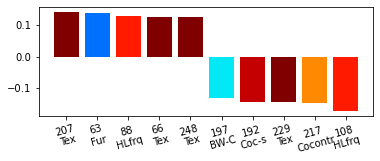

In [110]:
pcaxes_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/pca-axis'
roi = 'fullv4'#'shrdv1'#'shrdv4'
axes_file = f'sub-avg_ly-Incep3a_bm-{roi}_axis.npy'
axes = np.load(pjoin(pcaxes_dir, axes_file))

axis = axes[2]
num_top = 5
top_last = np.concatenate([np.sort(axis)[-num_top::][::-1], np.sort(axis)[0:num_top][::-1]])
top_last_ch = np.concatenate([np.argsort(axis)[-num_top::][::-1], np.argsort(axis)[0:num_top][::-1]])

def check_label(chennels):
    labels=[]
    for channel in chennels:
        for k, v in incep3a_labels.items():
            if channel in v:
                labels.append(k)
    return labels

colors = plt.cm.jet(np.linspace(0, 1, 18))
keys = list(incep3a_labels.keys())
labels = check_label(list(top_last_ch))
idx = np.array([keys.index(_) for _ in labels])
plt.figure(figsize=(6,2))

plt.bar(np.arange(2*num_top), height=top_last, color=colors[idx])
ticks = [f'{top_last_ch[i]}\n{labels[i]}' for i in range(len(labels))]
plt.xticks(np.arange(2*num_top),ticks, rotation=15)
plt.show()

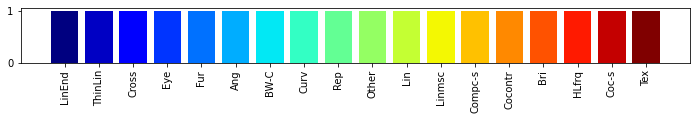

In [103]:
plt.figure(figsize=(12,1))

plt.bar(np.arange(18), height=np.ones(18), color=colors)
plt.xticks(np.arange(18),keys, rotation=90, )
plt.show()


In [104]:
check_label(list(top_last_ch))

['HLfrq',
 'Coc-s',
 'HLfrq',
 'Eye',
 'Bri',
 'Tex',
 'Compc-s',
 'Other',
 'HLfrq',
 'Coc-s']

###### pca loadings single channel plots

num of betas in LinEnd : (1148,)
num of betas in ThinLin : (1722,)
num of betas in Cross : (2296,)
num of betas in Eye : (2870,)
num of betas in Fur : (4018,)
num of betas in Ang : (4592,)
num of betas in BW-C : (5166,)
num of betas in Curv : (6314,)
num of betas in Rep : (6888,)
num of betas in Other : (8036,)
num of betas in Lin : (8036,)
num of betas in Linmsc : (8036,)
num of betas in Compc-s : (8036,)
num of betas in Cocontr : (8036,)
num of betas in Bri : (8610,)
num of betas in HLfrq : (8610,)
num of betas in Coc-s : (17220,)
num of betas in Tex : (37310,)


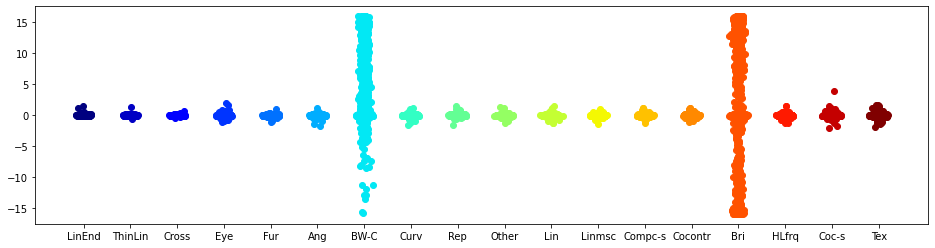

In [149]:
plot_data = ave_model_params_inbrain[np.array(shrd_v3),:]
plot_data = zscore(ave_model_params_inbrain[np.array(shrd_v3),:], axis=1)
# plot_data = zscore(ave_model_params_inbrain[np.array(shrd_v1),:], axis=0)
labels = list(incep3a_labels.keys())
colors = plt.cm.jet(np.linspace(0, 1, 18))
plt.figure(figsize=(16,4))
for key, value in incep3a_labels.items():
    label_betas = plot_data[:, np.array(value)].flatten()
    print(f'num of betas in {key} : {label_betas.shape}')
    plt.scatter(labels.index(key) * np.ones_like(label_betas)+0.05*np.random.randn(*label_betas.shape), label_betas, color=colors[labels.index(key)])
plt.xticks(np.arange(18), labels)
# plt.ylim([-5,5])
plt.show()

In [152]:
incep3a_labels['BW-C'], incep3a_labels['Bri']

([214, 208, 201, 223, 210, 197, 222, 204, 220],
 [216, 127, 22, 182, 162, 25, 249, 15, 28, 59, 29, 196, 206, 18, 247])

In [158]:
plot_data = zscore(ave_model_params_inbrain[np.array(shrd_v1),:])
ave_model_params_inbrain.shape
# np.max(plot_data), plot_data.mean(axis=0)

(59412, 256)

num of betas in channel 0 : (867,)
num of betas in channel 1 : (867,)
num of betas in channel 2 : (867,)
num of betas in channel 3 : (867,)
num of betas in channel 4 : (867,)
num of betas in channel 5 : (867,)
num of betas in channel 6 : (867,)
num of betas in channel 7 : (867,)
num of betas in channel 8 : (867,)
num of betas in channel 9 : (867,)
num of betas in channel 10 : (867,)
num of betas in channel 11 : (867,)
num of betas in channel 12 : (867,)
num of betas in channel 13 : (867,)
num of betas in channel 14 : (867,)
num of betas in channel 15 : (867,)
num of betas in channel 16 : (867,)
num of betas in channel 17 : (867,)
num of betas in channel 18 : (867,)
num of betas in channel 19 : (867,)
num of betas in channel 20 : (867,)
num of betas in channel 21 : (867,)
num of betas in channel 22 : (867,)
num of betas in channel 23 : (867,)


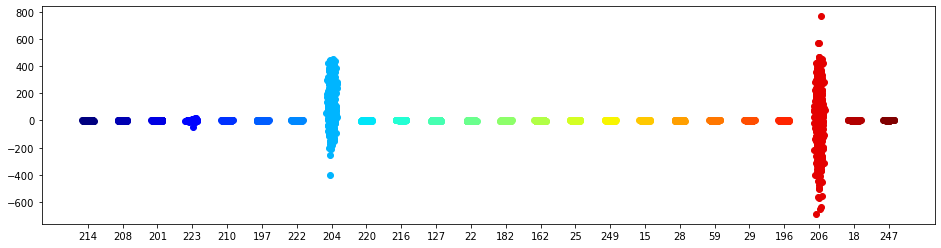

In [157]:
plot_data = ave_model_params_inbrain[np.array(shrd_v1),:]
# plot_data = zscore(ave_model_params_inbrain[np.array(shrd_v1),:], axis=1)
# plot_data = zscore(ave_model_params_inbrain[np.array(shrd_v1),:], axis=0)
labels = list(incep3a_labels.keys())

channel_list = incep3a_labels['BW-C'].copy()
channel_list.extend(incep3a_labels['Bri'])
colors = plt.cm.jet(np.linspace(0, 1, len(channel_list)))

plt.figure(figsize=(16,4))
for i, value in enumerate(channel_list):
    label_betas = plot_data[:, np.array(value)].flatten()
    print(f'num of betas in channel {i} : {label_betas.shape}')
    plt.scatter(i * np.ones_like(label_betas)+0.05*np.random.randn(*label_betas.shape), label_betas, color=colors[i])
plt.xticks(np.arange(len(channel_list)), channel_list)
# plt.ylim([-5,5])
plt.show()

In [167]:
save_data = np.zeros((2,91282))
save_data[:,np.array(full_vis)] = (ave_model_params_inbrain[np.array(full_vis), :][:, np.array([204,206])]).transpose()
save_ciftifile(save_data, './sthwrong.dtseries.nii')

#### single subjects

In [12]:
model_params_inbrain.shape

(9, 59412, 256)

204 min: -874.6057320088429 max:3223.1432568607042 mean:472.2757937167661 std: 447.74959208392073
206 min: -2563.764332036 max:4814.51052033244 mean:254.4948249942739 std: 471.38223283458217


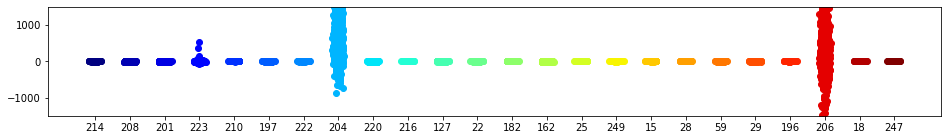

In [28]:
plot_data = model_params_inbrain[8, np.array(shrd_vis),:]
# plot_data = zscore(ave_model_params_inbrain[np.array(shrd_v1),:], axis=1)
# plot_data = zscore(ave_model_params_inbrain[np.array(shrd_v1),:], axis=0)
labels = list(incep3a_labels.keys())

channel_list = incep3a_labels['BW-C'].copy()
channel_list.extend(incep3a_labels['Bri'])
colors = plt.cm.jet(np.linspace(0, 1, len(channel_list)))

plt.figure(figsize=(16,2))
for i, value in enumerate(channel_list):
    label_betas = plot_data[:, np.array(value)].flatten()
    # print(f'num of betas in channel {i} : {label_betas.shape}')
    if i == channel_list.index(204) or i == channel_list.index(206):
        print(value, f'min: {np.nanmin(label_betas)} max:{np.nanmax(label_betas)} mean:{np.nanmean(label_betas)} std: {np.nanstd(label_betas)}')
    plt.scatter(i * np.ones_like(label_betas)+0.05*np.random.randn(*label_betas.shape), label_betas, color=colors[i])
plt.xticks(np.arange(len(channel_list)), channel_list)
plt.ylim([-1500,1500])
plt.show()

In [42]:
featureidx = 204
np.nanpercentile(model_params_inbrain[:, np.array(full_vis), :][:, :, featureidx], 95)

660.2895434495612

In [37]:
save_data = np.zeros((9,91282))
save_data[:,np.array(full_vis)] = (model_params_inbrain[:, np.array(full_vis), :][:, :, 223])
save_ciftifile(save_data, './ch223.dtseries.nii')

In [55]:
for feature in channel_list:
    params_map = model_params_inbrain[:, np.array(shrd_vis), :][:, :, feature]
    params_map = np.nan_to_num(params_map)
    print((9*np.nanmean(np.corrcoef(params_map), axis=None)-1)/8)

-0.013947960764640888
-0.01840622956865874
-0.018387627880157506
0.026457242621041932
-0.02212894181269079
0.0755360506454682
-0.01290266004308567
0.029040097832621625
-0.025846354937073768
-0.010995459588386325
0.036155188162213525
0.050150375613452175
0.01892655760891479
0.054464349044554994
0.03519629736585239
-0.019238326165887373
0.03734920160073979
-0.00189412781140387
-0.010982548079176854
-0.012849980248610421
-0.0010367381475587245
-0.0073569988911425105
-0.010064799412595055
0.05950620798326578


In [52]:
np.where(np.isnan(params_map)==1)

(array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5]),
 array([ 715,   48,   64,   65,   66,   77,   78,   84,  160,  161,  325,
         347,  367,  405,  479,  726,  775,  776,  790,  791,  792,  793,
         805,  806,  807,  819,  820,  832,  844,  867,  878,  888,  889,
        1241, 1278, 1280, 1281, 1599, 1600, 1602, 1615, 1663, 1988, 1989,
        2003, 2004, 2043, 2044, 2085, 2086,  658,  710, 1037, 1077, 1078,
        1162, 1174, 1254, 1613, 1648, 1649, 1663, 1981, 1985, 1986, 1989,
        2027, 2067, 2068, 2071, 2108, 2109, 2147, 2180, 2211, 2212, 2247,
        2248, 2259,  122]))

In [56]:
model_params_inbrain[:, np.array(full_vis), :].shape

(9, 4193, 256)

In [59]:
pca_axes = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/pca-axis/sub-avg_ly-inception3a_bm-shrdvis_axis.npy')
trans_params = np.dot(model_params_inbrain[:, np.array(full_vis), :], pca_axes.T)

In [60]:
trans_params.shape

(9, 4193, 10)

In [61]:
for feature in range(10):
    params_map = trans_params[:,:,feature]
    params_map = np.nan_to_num(params_map)
    print((9*np.nanmean(np.corrcoef(params_map), axis=None)-1)/8)

0.04036447106730698
-0.012917770407333357
0.05103032945916783
-0.012179779921679068
-0.011678562516225385
0.0330054432623777
-0.008365669361023995
-0.01582234452279528
-0.013586202279371032
0.0037176737661372417
